In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation, EventList
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
# from gammapy.makers.utils import make_edisp_map, make_edisp_kernel_map
from gammapy.irf import PSFMap, PSF3D
from utils import EdispInv

from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PointSpatialModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)

1.0


## Create a MapDatset

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [3]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ENERGY = 1 # TeV
tab=obs1.events.table
tab["ENERGY"] = 1
obs1._events = EventList(tab)
ebins = np.geomspace(ENERGY/1.05,ENERGY*1.05,3) # a course binning in true energy just around 1 energy
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=16, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.01,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapDatasetMaker(selection=['psf', 'exposure'])
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)
dataset = maker.run(reference, obs1)

CPU times: user 229 ms, sys: 22.5 ms, total: 251 ms
Wall time: 273 ms


In [5]:
def make_psf_factors(psf, geom, events, position=None, pointing=None):
    """Calculate the energy dispersion factors for the events.

        Parameters
        ----------
        psf : The Point Spead Function. Supported classes are:
            `~gammapy.irf.PSFMap` (projected)
            `~gammapy.irf.PSF3D` (not yet projected, needs pointing)
        geom : `~gammapy.maps.WcsGeom`
            The true geometry for the numeric integration
        events : `~gammapy.data.EventList`
            EventList with the relevant events
        position : `~astropy.coordinates.SkyCoord`
            Position (centre) of the model at which the psf is evaluated. 
            Should be a single coordinate. If None the skycoords of the geom are used.
        pointing : `~astropy.coordinates.SkyCoord`
            Pointing position of the observation. Should be a single coordinate.
            It needs to be give in case of the EnergyDispersion2D        

        Returns
        -------
        psf : `~astropy.units.quantity.Quantity`
            The PSF kernels for the events. 
            The shape is (Nevents,Nebins,lon,lat) with dP/dOmega, 
            the differential probablity for each true pixel 
            to reconstruct at the event's position.
        """
   
    e_axis_true = geom.axes['energy_true']
    geom_radec = geom.get_coord(sparse=True).skycoord.squeeze()
    rad = events.radec[:,None,None,None].separation(geom_radec)
    
    coords = {'skycoord': position or geom_radec[None,None,...]}
    coords['rad'] = rad # event,e_true,lon,lat 
    
    if isinstance(psf, PSFMap):
        if 'energy' in psf.psf_map.geom.axes_names:
            coords['energy'] = events.energy[:,None,None,None]
        if 'energy_true' in psf.psf_map.geom.axes_names:
            coords['energy_true'] = e_axis_true.center[:,None,None]

        factors = psf.psf_map.interp_by_coord(coords, fill_value=0.)
        unit=psf.psf_map.unit  # for some reason the interpolated values have no units
        factors *= unit
            
    elif isinstance(psf, PSF3D):
        if 'energy' in psf.axes.names:
            coords['energy'] = events.energy[:,None,None,None]
        if 'energy_true' in psf.axes.names:
            coords['energy_true'] = e_axis_true.center[:,None,None]

        coords['offset'] = coords['skycoord'].separation(pointing)
        del coords['skycoord']
        factors = psf.evaluate(method='linear', **coords)
        
    else:
        raise ValueError("No valid psf class. \
Need one of the following: PSFMap, PSF3D")
    return factors

## Compare the factors

In [6]:
%%time
geom_int = geom.cutout(crab_pos, '0.5 deg').to_image().to_cube([energy_axis_true])
events = obs1.events.select_energy([1,50]*u.TeV)
events = events.select_offset([0.,2.0]*u.deg)
mask_offset = events.radec.separation(crab_pos) < 0.7*u.deg
events=events.select_row_subset(mask_offset)
psf_etrue = make_psf_factors(dataset.psf, geom_int, events, crab_pos)

CPU times: user 2.39 s, sys: 885 ms, total: 3.28 s
Wall time: 3.28 s


In [7]:
%%time
pmap_ereco = dataset.psf.copy()
pmap_ereco.psf_map.geom.axes['energy_true']._name='energy'
psf_ereco = make_psf_factors(pmap_ereco, geom_int, events, crab_pos)

CPU times: user 1.33 s, sys: 162 ms, total: 1.49 s
Wall time: 1.49 s


In [8]:
%%time
psf_obs = make_psf_factors(obs1.psf, geom_int,events, crab_pos, obs1.pointing_radec)

CPU times: user 1.26 s, sys: 419 ms, total: 1.68 s
Wall time: 1.68 s


In [9]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.04 deg', frame = 'galactic'),
    spectral_model=TemplateSpectralModel(energy=geom_int.axes['energy_true'].center,
                              values=1/geom_int.axes['energy_true'].bin_width * u.Unit("cm-2 s-1")
                             ),
    name='crab_model_gauss'
    )
dataset.exposure.data =1
dataset.models=[model_gauss]

In [10]:
unit=u.Unit("sr-1")

npred_true=model_gauss.integrate_geom(geom_int)
npred_true *= dataset.exposure.interp_to_geom(geom_int)

response_proj = (psf_etrue * npred_true).sum(axis=(2,3)).to_value(unit)
response_obs = (psf_obs * npred_true).sum(axis=(2,3)).to_value(unit)

# average over the energies (with edisp factors this would be a sum)
response_proj = np.mean(response_proj, axis=1)
response_obs = np.mean(response_obs, axis=1)

# compare to the binned case
npred_crab=dataset.npred_signal(model_name="crab_model_gauss")
npred_crab.data /= npred_crab.geom.solid_angle().to_value(1/unit)
response_bin = npred_crab.interp_by_coord(events.map_coord(npred_crab.geom))

sep_model =events.radec.separation(crab_pos)

Text(0, 0.5, 'response [1 / sr]')

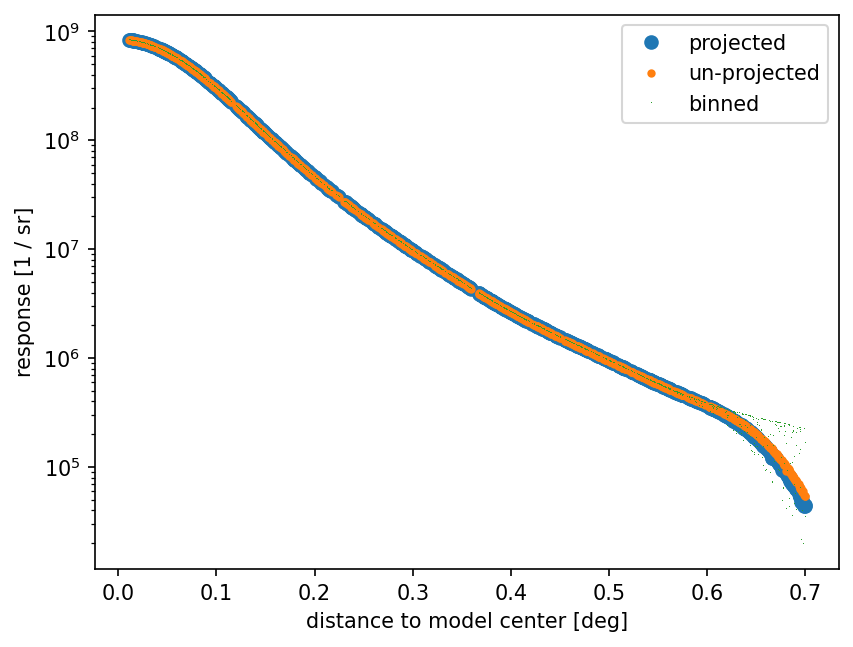

In [11]:
plt.figure(dpi=150)
plt.plot(sep_model, response_proj, "o", label="projected")
plt.plot(sep_model, response_obs, ".", label="un-projected")
plt.plot(sep_model, response_bin, ",", label="binned")
plt.legend()
plt.semilogy()

plt.xlabel("distance to model center [deg]")
plt.ylabel(f"response [{unit}]")